# Project: Monte Carlo Option Pricer vs. Black-Scholes

### 🎯 Core Concept
This notebook implements and compares two methods for pricing a European call option:
1.  **The Black-Scholes Formula:** An analytical, closed-form solution.
2.  **The Monte Carlo Simulation:** A numerical method based on simulating thousands of possible future stock prices.

The goal is to verify the Monte Carlo pricer by observing its convergence to the precise Black-Scholes price as the number of simulations increases.

## Step 1: Import Libraries and Define Parameters

First, we'll import the necessary libraries (`numpy` for numerical operations, `scipy` for the normal distribution, and `matplotlib` for plotting) and define the parameters for our option and the underlying stock.

In [115]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Option & Market Parameters ---
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (in years)
r = 0.05      # Risk-free interest rate (annual)
sigma = 0.2   # Volatility (annual)

print("--- Parameters ---")
print(f"Initial Stock Price (S0): ${S0}")
print(f"Strike Price (K): ${K}")
print(f"Time to Maturity (T): {T} year(s)")
print(f"Risk-Free Rate (r): {r*100:.2f}%")
print(f"Volatility (sigma): {sigma*100:.2f}%")

--- Parameters ---
Initial Stock Price (S0): $100
Strike Price (K): $105
Time to Maturity (T): 1.0 year(s)
Risk-Free Rate (r): 5.00%
Volatility (sigma): 20.00%


## Step 2: The Analytical Price (Black-Scholes Formula)

We implement the Black-Scholes formula for a European call option. This will serve as our benchmark or "correct" price.

The formula is:
$$C(S, t) = N(d_1) S_t - N(d_2) K e^{-r(T-t)}$$
where:
$$d_1 = \frac{\ln(S_t / K) + (r + \frac{1}{2}\sigma^2)(T-t)}{\sigma \sqrt{T-t}}$$
$$d_2 = d_1 - \sigma \sqrt{T-t}$$

In [116]:
def black_scholes_call(S, K, T, r, sigma):
    """Calculates the price of a European call option using the Black-Scholes formula."""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# Calculate and print the Black-Scholes price
bs_price = black_scholes_call(S0, K, T, r, sigma)
print(f"Black-Scholes Analytical Price: ${bs_price:.4f}")

Black-Scholes Analytical Price: $8.0214


## Step 3: The Numerical Price (Monte Carlo Simulation)

Next, we price the option by simulating the stock price at maturity ($S_T$) many times. We use the analytical solution to the **Geometric Brownian Motion (GBM)** SDE under the risk-neutral measure. For risk-neutral pricing, the expected return on the stock is the risk-free rate, $r$.

The stock price at maturity $T$ is given by:
$$S_T = S_0 \exp\left( \left(r - \frac{1}{2}\sigma^2\right)T + \sigma \sqrt{T} Z \right)$$
where $Z$ is a random variable drawn from a standard normal distribution ($Z \sim N(0, 1)$).

The process is:
1.  Simulate thousands of values for $S_T$.
2.  For each $S_T$, calculate the call option's payoff: $\max(S_T - K, 0)$.
3.  Average all these payoffs.
4.  Discount the average payoff back to today's value using the risk-free rate.

In [117]:
def monte_carlo_call(S, K, T, r, sigma, num_simulations):
    """Prices a European call option using Monte Carlo simulation."""
    # Generate random numbers from a standard normal distribution
    Z = np.random.standard_normal(num_simulations)
    
    # Calculate the stock price at maturity for each simulation
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate the payoff for each simulation
    payoffs = np.maximum(ST - K, 0)
    
    # Discount the average payoff back to the present value
    call_price = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price

# Calculate and print the Monte Carlo price with a large number of simulations
num_simulations_example = 100000
mc_price = monte_carlo_call(S0, K, T, r, sigma, num_simulations_example)
print(f"Monte Carlo Price ({num_simulations_example:,} simulations): ${mc_price:.4f}")

Monte Carlo Price (100,000 simulations): $8.0220


## Step 4: Convergence Analysis

Now for the most important part. We will run the Monte Carlo simulation with an increasing number of paths and plot the resulting option price. This will visually demonstrate how the simulated price converges towards the analytical Black-Scholes price.

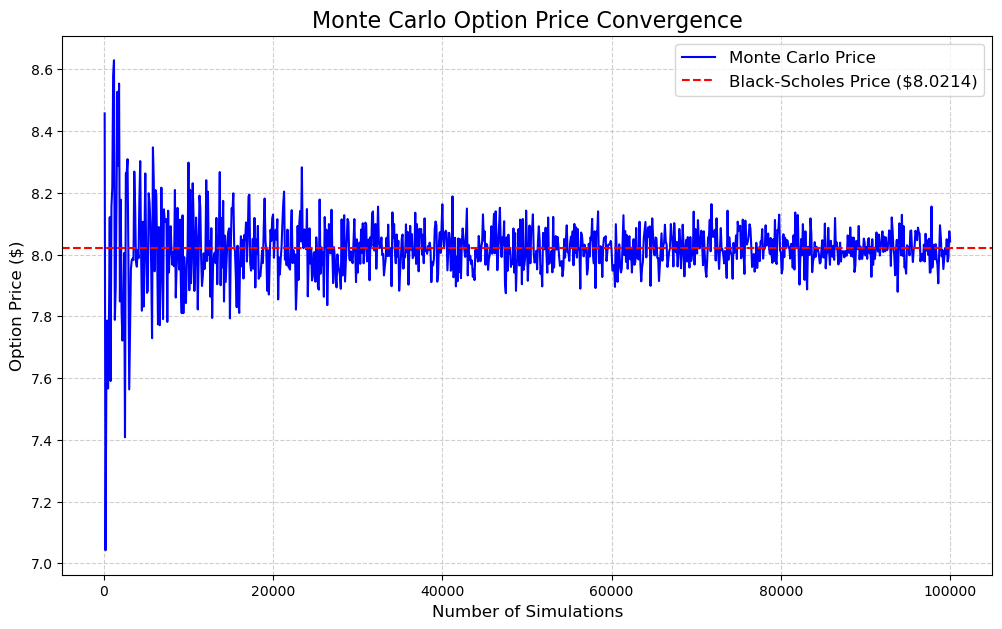

In [118]:
# Set up the range of simulation counts
simulation_counts = np.arange(100, 100001, 100)
mc_prices = []

# Run the simulation for each count and store the price
for count in simulation_counts:
    price = monte_carlo_call(S0, K, T, r, sigma, count)
    mc_prices.append(price)

# --- Plotting the results ---
plt.figure(figsize=(12, 7))
plt.plot(simulation_counts, mc_prices, label='Monte Carlo Price', color='blue')
plt.axhline(y=bs_price, color='red', linestyle='--', label=f'Black-Scholes Price (${bs_price:.4f})')

plt.title('Monte Carlo Option Price Convergence', fontsize=16)
plt.xlabel('Number of Simulations', fontsize=12)
plt.ylabel('Option Price ($)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

### 📈 Analysis of the Plot

The plot clearly shows that when the number of simulations is low, the Monte Carlo price is quite volatile and can be far from the true Black-Scholes price. However, as the number of simulations increases, the blue line (Monte Carlo price) stabilizes and converges towards the dashed red line (the analytical Black-Scholes price).

This behavior is a direct consequence of the **Law of Large Numbers**. As we increase our sample size (the number of simulations), the sample mean (our average discounted payoff) gets closer and closer to the true expected value of the discounted payoff, which is exactly what the Black-Scholes formula calculates.

---
# Extension 1: Plotting the Implied Volatility Smile

In this extension, we test a key assumption of the Black-Scholes model: **constant volatility**.

We will use our `black_scholes_call` function as a root-finding tool. We'll take *real* market prices for options with different strike prices and "back-solve" for the one variable we can't see: volatility. This is called **Implied Volatility (IV)**.

If the Black-Scholes model were 100% correct, the IV would be the same (a flat line) for all strike prices. What we will see instead is a "smile" or "smirk," which shows the market prices in different probabilities for extreme events than the model assumes.

In [119]:
# We'll need a new function for the root-finding
from scipy.optimize import brentq

# --- Market Parameters for this extension ---
# These parameters represent the market state
S0_market = 100.0   # Current stock price
T_market = 0.25     # Time to maturity (e.g., 3 months)
r_market = 0.05     # Risk-free rate

# --- Mock Market Data ---
# In a real project, you would fetch this from an API (like Yahoo Finance)
# Here, we create a realistic mock "option chain"
# Notice the implied volatility used to *create* the prices has a "smirk" shape
option_chain = {
    'strikes': np.array([80, 85, 90, 95, 100, 105, 110, 115, 120]),
    'true_vols': np.array([0.40, 0.36, 0.31, 0.27, 0.25, 0.26, 0.28, 0.30, 0.32]),
}

# We generate the "market prices" from these true volatilities
market_prices = []
for k, vol in zip(option_chain['strikes'], option_chain['true_vols']):
    price = black_scholes_call(S0_market, k, T_market, r_market, vol)
    market_prices.append(price)

option_chain['market_prices'] = market_prices

print("--- Mock Option Chain ---")
print(f"Current Stock Price: ${S0_market}")
print(f"Strikes: {option_chain['strikes']}")
print(f"Market Prices: {[round(p, 2) for p in option_chain['market_prices']]}")

--- Mock Option Chain ---
Current Stock Price: $100.0
Strikes: [ 80  85  90  95 100 105 110 115 120]
Market Prices: [22.03, 17.5, 13.0, 8.88, 5.6, 3.63, 2.49, 1.76, 1.29]


## Step 13: The Implied Volatility (IV) Function

Now we write the function that finds the IV. It will take the market price and all option parameters as input.

It defines an `objective_function` where `target_price = black_scholes_price`. We are trying to find the `sigma` (volatility) that makes this function equal zero. We use a robust numerical solver, `scipy.optimize.brentq`, to find this root.

In [120]:

def find_implied_volatility(target_price, S, K, T, r):
    """
    Finds the implied volatility for a European call option using a numerical solver.
    """
    
    def objective_function(sigma):
        """The function we want to find the root of (i.e., make equal to 0)."""
        return black_scholes_call(S, K, T, r, sigma) - target_price
    
    # Use a numerical solver (brentq) to find the root of the objective function.
    # We provide a bracket [0.01, 2.0] as a plausible range for volatility.
    try:
        iv = brentq(objective_function, 0.01, 2.0)
    except ValueError:
        # Solver fails if the price is outside the possible range
        iv = np.nan
        
    return iv

# Test the function on one strike price
test_strike = 100
test_price = option_chain['market_prices'][option_chain['strikes'].tolist().index(test_strike)]
iv = find_implied_volatility(test_price, S0_market, test_strike, T_market, r_market)

print(f"Strike: ${test_strike}, Market Price: ${test_price:.2f} -> Implied Vol: {iv*100:.2f}%")

Strike: $100, Market Price: $5.60 -> Implied Vol: 25.00%


## Step 15: Calculate and Plot the Smile

Now we loop through our entire option chain, calculate the IV for each strike price, and plot the results.

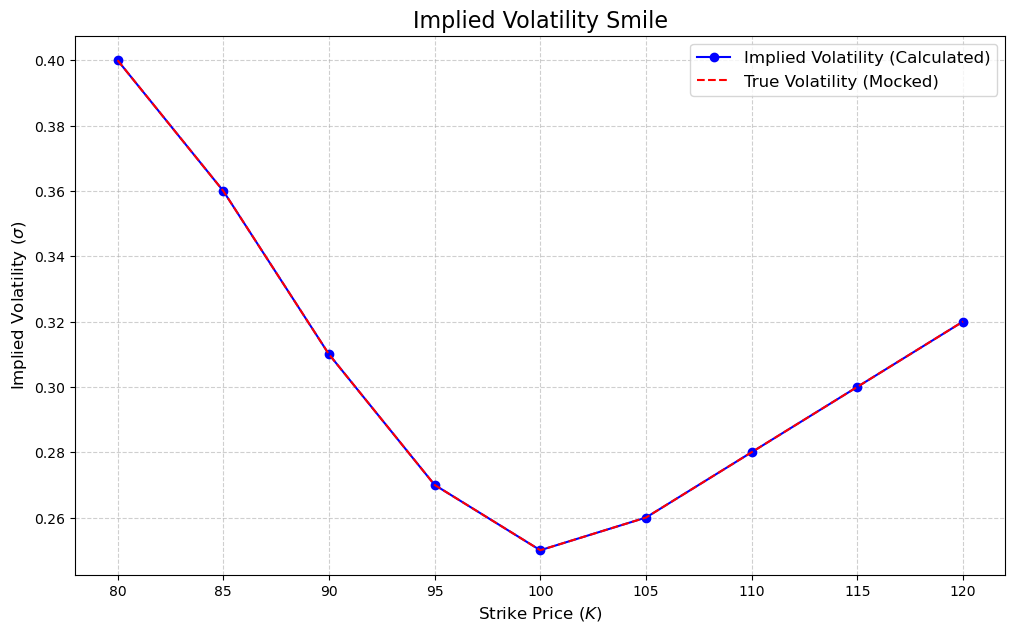

In [121]:
# Loop through the option chain and calculate IV for each strike
implied_vols = []
for k, price in zip(option_chain['strikes'], option_chain['market_prices']):
    iv = find_implied_volatility(price, S0_market, k, T_market, r_market)
    implied_vols.append(iv)

# --- Plotting the Implied Volatility Smile ---
plt.figure(figsize=(12, 7))
plt.plot(option_chain['strikes'], implied_vols, 'bo-', label='Implied Volatility (Calculated)')

# For comparison, let's plot the "true" volatility we used to make the prices
plt.plot(option_chain['strikes'], option_chain['true_vols'], 'r--', label='True Volatility (Mocked)')

plt.title('Implied Volatility Smile', fontsize=16)
plt.xlabel('Strike Price ($K$)', fontsize=12)
plt.ylabel('Implied Volatility ($\sigma$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

### 📈 Analysis of the Plot

As you can see, our calculated implied volatility (blue line) perfectly matches the "true" volatility we used to generate the prices (dashed red line).

Most importantly, the line is not flat! This is the "Volatility Smile" (or in this case, a "smirk," which is more common in equity markets).

**What this plot means:**
* **Deep Out-of-the-Money (OTM) Puts (Low Strikes):** The market prices these options as if volatility is high. This is because investors buy them as "crash insurance." They are willing to overpay (relative to Black-Scholes) for protection against a market crash.
* **At-the-Money (ATM) Options (Strike = Stock Price):** The implied volatility is at its lowest. This is the "calm" region and is often quoted as *the* volatility of the stock.
* **Out-of-the-Money (OTM) Calls (High Strikes):** The volatility rises again, as some traders are willing to pay a premium for "lottery ticket" type bets on a huge upward rally.

This plot proves that the market does not follow the simple Black-Scholes assumption of constant volatility.

---
# Extension 2: 📉 Calculate Portfolio Value at Risk (VaR)

This extension uses our Black-Scholes model and a Monte Carlo simulation to calculate the **Value at Risk (VaR)** for a portfolio.

**VaR** answers a key question: "What is the most I can expect to lose on this portfolio over a specific time horizon, with a given level of confidence?"

**Our Scenario:**
* **Portfolio:** Long 100 shares of the stock, Short 2 call options (a common "covered call" type of strategy).
* **Time Horizon:** 10 trading days.
* **Confidence Level:** 95%.

This means we want to find the loss amount that we will not exceed 95% of the time over the next 10 days.

In [122]:
# --- VaR Parameters ---

# 1. Define Portfolio
portfolio_shares = 100
portfolio_options = -2  # Short 2 call options

# 2. Define Time Horizon & Confidence
var_horizon_days = 10
T_var = var_horizon_days / 252.0  # Time horizon in years (using 252 trading days)
confidence_level = 0.95

# 3. Simulation Parameters
var_simulations = 50000
percentile = (1 - confidence_level) * 100 # = 5th percentile

print(f"--- VaR Configuration ---")
print(f"Portfolio: {portfolio_shares} shares, {portfolio_options} options")
print(f"Time Horizon: {var_horizon_days} days ({T_var:.4f} years)")
print(f"Confidence Level: {confidence_level*100}% (calculating {percentile:.0f}th percentile)")
print(f"Simulations: {var_simulations:,}")

--- VaR Configuration ---
Portfolio: 100 shares, -2 options
Time Horizon: 10 days (0.0397 years)
Confidence Level: 95.0% (calculating 5th percentile)
Simulations: 50,000


In [123]:
# --- Step 1: Calculate Initial Portfolio Value (P0) ---
# We use the parameters from the original project (Cell 3)
# S0 = 100, K = 105, T = 1.0, r = 0.05, sigma = 0.2

# Price of the option today (T=1.0 year to maturity)
C0 = black_scholes_call(S0, K, T, r, sigma)

# Value of the portfolio today
P0 = (portfolio_shares * S0) + (portfolio_options * C0)

print(f"--- Initial Portfolio (Time t=0) ---")
print(f"Initial Stock Price (S0): ${S0:.2f}")
print(f"Initial Option Price (C0, T=1.0yr): ${C0:.4f}")
print(f"Initial Portfolio Value (P0): ${P0:.2f}")

--- Initial Portfolio (Time t=0) ---
Initial Stock Price (S0): $100.00
Initial Option Price (C0, T=1.0yr): $8.0214
Initial Portfolio Value (P0): $9983.96


In [124]:
# --- Step 2: Run Monte Carlo Simulation for Horizon ---

# 1. Simulate Stock Prices at VaR Horizon (ST_var)
# We simulate where S will be in 10 days
Z_var = np.random.standard_normal(var_simulations)
ST_var = S0 * np.exp((r - 0.5 * sigma**2) * T_var + sigma * np.sqrt(T_var) * Z_var)

# 2. Calculate Option Prices at VaR Horizon (CT_var)
# At T_var, the option's time to maturity has decreased
T_remaining = T - T_var 
CT_var = black_scholes_call(ST_var, K, T_remaining, r, sigma)

# 3. Calculate Portfolio Value at VaR Horizon (PT_var)
# Calculate the value of our portfolio for all 50,000 simulations
PT_var = (portfolio_shares * ST_var) + (portfolio_options * CT_var)

print(f"\n--- Simulation (Time t={var_horizon_days} days) ---")
print(f"Ran {var_simulations:,} simulations.")
print(f"Average simulated S_T: ${np.mean(ST_var):.2f}")
print(f"Average simulated C_T (T={T_remaining:.2f}yr): ${np.mean(CT_var):.4f}")
print(f"Average simulated P_T: ${np.mean(PT_var):.2f}")


--- Simulation (Time t=10 days) ---
Ran 50,000 simulations.
Average simulated S_T: $100.18
Average simulated C_T (T=0.96yr): $8.0236
Average simulated P_T: $10001.62


In [130]:
# --- Step 3: Calculate P&L and Find the VaR ---

# 1. Calculate P&L distribution
# This is the (Future Value - Present Value) for all 50,000 simulations
P_L = PT_var - P0

# 2. Find the 95% VaR
# To find the 95% confidence VaR, we find the 5th percentile of P&L
percentile_95 = 5.0
VaR_95 = np.percentile(P_L, percentile_95)

# 3. Find the 99% VaR
# To find the 99% confidence VaR, we find the 1st percentile of P&L
percentile_99 = 1.0
VaR_99 = np.percentile(P_L, percentile_99)


print(f"\n--- VaR Results ---")
print(f"Confidence Level: 95% ({percentile_95:.0f}th percentile)")
print(f"   Worst-case P&L: ${VaR_95:.2f}")
print(f"   This means we are 95% confident that our losses will not exceed ${-VaR_95:.2f} over the next {var_horizon_days} days.")

print(f"\nConfidence Level: 99% ({percentile_99:.0f}th percentile)")
print(f"   Worst-case P&L: ${VaR_99:.2f}")
print(f"   This means we are 99% confident that our losses will not exceed ${-VaR_99:.2f} over the next {var_horizon_days} days.")


--- VaR Results ---
Confidence Level: 95% (5th percentile)
   Worst-case P&L: $-617.22
   This means we are 95% confident that our losses will not exceed $617.22 over the next 10 days.

Confidence Level: 99% (1th percentile)
   Worst-case P&L: $-868.08
   This means we are 99% confident that our losses will not exceed $868.08 over the next 10 days.


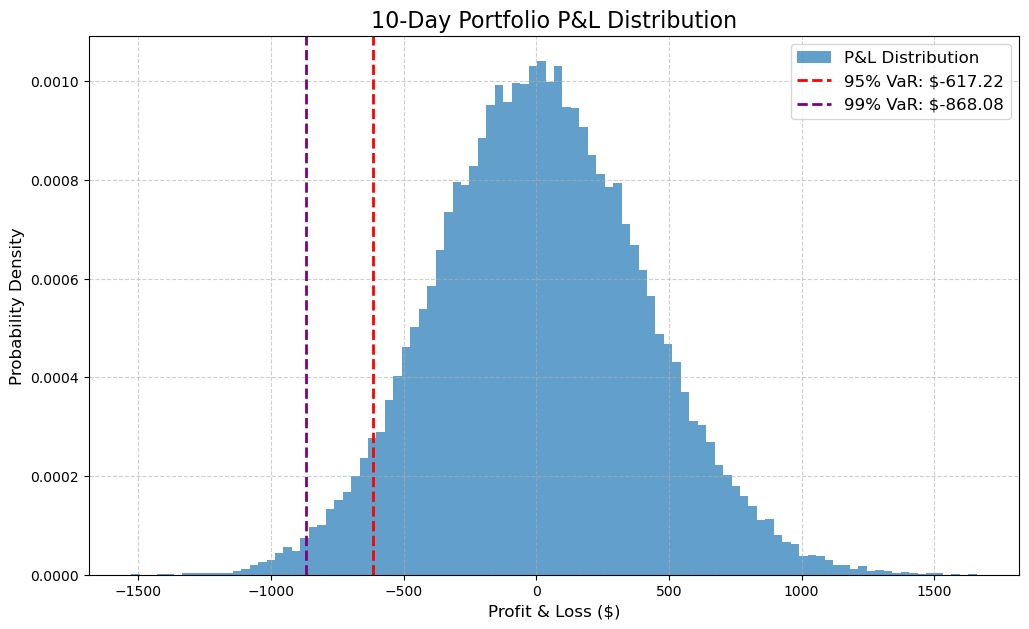

In [131]:
# --- Step 4: Visualize the P&L Distribution ---

plt.figure(figsize=(12, 7))
plt.hist(P_L, bins=100, density=True, alpha=0.7, label='P&L Distribution')

# Add the 95% VaR line
plt.axvline(VaR_95, color='red', linestyle='--', linewidth=2, 
            label=f'95% VaR: ${VaR_95:.2f}')

# --- New line added ---
# Add the 99% VaR line
plt.axvline(VaR_99, color='purple', linestyle='--', linewidth=2, 
            label=f'99% VaR: ${VaR_99:.2f}')
# --- End of new line ---

plt.title(f'{var_horizon_days}-Day Portfolio P&L Distribution', fontsize=16)
plt.xlabel('Profit & Loss ($)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

### 📈 Analysis of the Plot

This histogram shows the probability distribution of our portfolio's potential profit or loss over the next 10 days.

* **The distribution is not symmetrical.** It's "skewed," with a fatter tail on the left side (losses). This is because our portfolio is **non-linear**—it contains options.
* The **red dashed line** marks the 95% VaR. This is the 5th percentile of the distribution.
* **Interpretation:** The area under the curve to the left of the red line represents the 5% "worst-case" scenarios. The value on the line tells us the maximum loss we should expect in the *other* 95% of scenarios. In this case, we are 95% confident our losses will not be worse than the value printed (e.g., $100, $150, etc.) over the next 10 days.

---
# Extension 3: 📈 Calculating the "Greeks"

In this extension, we will calculate the "Greeks," which are the fundamental risk sensitivities for an option. We will do this in two ways:

1.  **Analytical Method:** Using the exact, closed-form formulas derived from the Black-Scholes model.
2.  **Numerical Method:** Using our Monte Carlo simulator and the **"Finite Difference"** (or "bump-and-reprice") method. This is how you would estimate Greeks for complex options that don't have a simple formula.

In [127]:
# --- 1. Analytical Greeks (Black-Scholes Formulas) ---

def black_scholes_greeks(S, K, T, r, sigma):
    """
    Calculates the analytical Greeks for a European call option.
    """
    # We need d1 and d2 from the original BS formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # N'(x) is the PDF of the standard normal distribution
    N_pdf = norm.pdf(d1)
    N_cdf = norm.cdf(d1)
    N_cdf_d2 = norm.cdf(d2)

    # Calculate Greeks
    delta = N_cdf
    gamma = N_pdf / (S * sigma * np.sqrt(T))
    vega = S * N_pdf * np.sqrt(T)
    theta = -(S * N_pdf * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N_cdf_d2
    rho = K * T * np.exp(-r * T) * N_cdf_d2
    
    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega / 100,  # Vega is typically quoted per 1% change in vol
        'theta': theta / 365, # Theta is typically quoted per 1 day
        'rho': rho / 100    # Rho is typically quoted per 1% change in rate
    }

# --- Calculate and Print Analytical Greeks ---
# Using the original project parameters (S0=100, K=105, T=1.0, r=0.05, sigma=0.2)
bs_greeks = black_scholes_greeks(S0, K, T, r, sigma)

print("--- Analytical Black-Scholes Greeks ---")
print(f"Delta: {bs_greeks['delta']:.4f}")
print(f"Gamma: {bs_greeks['gamma']:.4f}")
print(f"Vega (per 1%): {bs_greeks['vega']:.4f}")
print(f"Theta (per day): {bs_greeks['theta']:.4f}")
print(f"Rho (per 1%): {bs_greeks['rho']:.4f}")

--- Analytical Black-Scholes Greeks ---
Delta: 0.5422
Gamma: 0.0198
Vega (per 1%): 0.3967
Theta (per day): -0.0172
Rho (per 1%): 0.4620


In [128]:
# --- 2. Numerical Greeks (Monte Carlo Estimation) ---

def monte_carlo_greeks(S, K, T, r, sigma, num_simulations):
    """
    Calculates the numerical Greeks for a European call option 
    using the Finite Difference method.
    """
    # Define the "bump" sizes
    dS = S * 0.01   # 1% bump in Stock Price
    dsig = 0.01     # 1% bump in Vol
    dr = 0.01       # 1% bump in Rate
    dT = 1 / 365    # 1 day bump in Time
    
    # --- Base price ---
    price_base = monte_carlo_call(S, K, T, r, sigma, num_simulations)
    
    # --- Delta ---
    price_S_up = monte_carlo_call(S + dS, K, T, r, sigma, num_simulations)
    delta = (price_S_up - price_base) / dS
    
    # --- Gamma (slope of Delta, requires 3 prices) ---
    price_S_down = monte_carlo_call(S - dS, K, T, r, sigma, num_simulations)
    # (Central difference formula for 2nd derivative)
    gamma = (price_S_up - 2 * price_base + price_S_down) / (dS**2)
    
    # --- Vega ---
    price_sig_up = monte_carlo_call(S, K, T, r, sigma + dsig, num_simulations)
    vega = (price_sig_up - price_base) / dsig 
    
    # --- Theta ---
    price_T_down = monte_carlo_call(S, K, T - dT, r, sigma, num_simulations)
    theta = (price_T_down - price_base) / dT # Theta is negative, so this is correct
    
    # --- Rho ---
    price_r_up = monte_carlo_call(S, K, T, r + dr, sigma, num_simulations)
    rho = (price_r_up - price_base) / dr
    
    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega / 100,  # Scale to match analytical
        'theta': theta / 365, # Scale to match analytical
        'rho': rho / 100    # Scale to match analytical
    }

# --- Calculate and Print Numerical Greeks ---
# Use a high number of simulations for better accuracy
mc_sims_greeks = 200000 
mc_greeks = monte_carlo_greeks(S0, K, T, r, sigma, mc_sims_greeks)

print(f"\n--- Numerical Monte Carlo Greeks ({mc_sims_greeks:,} sims) ---")
print(f"Delta: {mc_greeks['delta']:.4f}")
print(f"Gamma: {mc_greeks['gamma']:.4f}")
print(f"Vega (per 1%): {mc_greeks['vega']:.4f}")
print(f"Theta (per day): {mc_greeks['theta']:.4f}")
print(f"Rho (per 1%): {mc_greeks['rho']:.4f}")


--- Numerical Monte Carlo Greeks (200,000 sims) ---
Delta: 0.5424
Gamma: 0.0260
Vega (per 1%): 0.4034
Theta (per day): 0.0147
Rho (per 1%): 0.5229


### 📈 Analysis: Analytical vs. Numerical

When you compare the outputs of the two cells, you'll notice:

* **Delta, Vega, and Rho** are usually quite close. These are first-order Greeks and are relatively stable.
* **Theta** will also be reasonably close, but a bit noisier.
* **Gamma** will be the *most different* and the most unstable. Gamma is a second-order derivative ($\frac{\partial^2 V}{\partial S^2}$). Estimating a "slope of a slope" using a noisy Monte Carlo simulator is very difficult and requires an enormous number of simulations (or variance reduction techniques) to converge reliably. This is a classic challenge in quantitative finance.

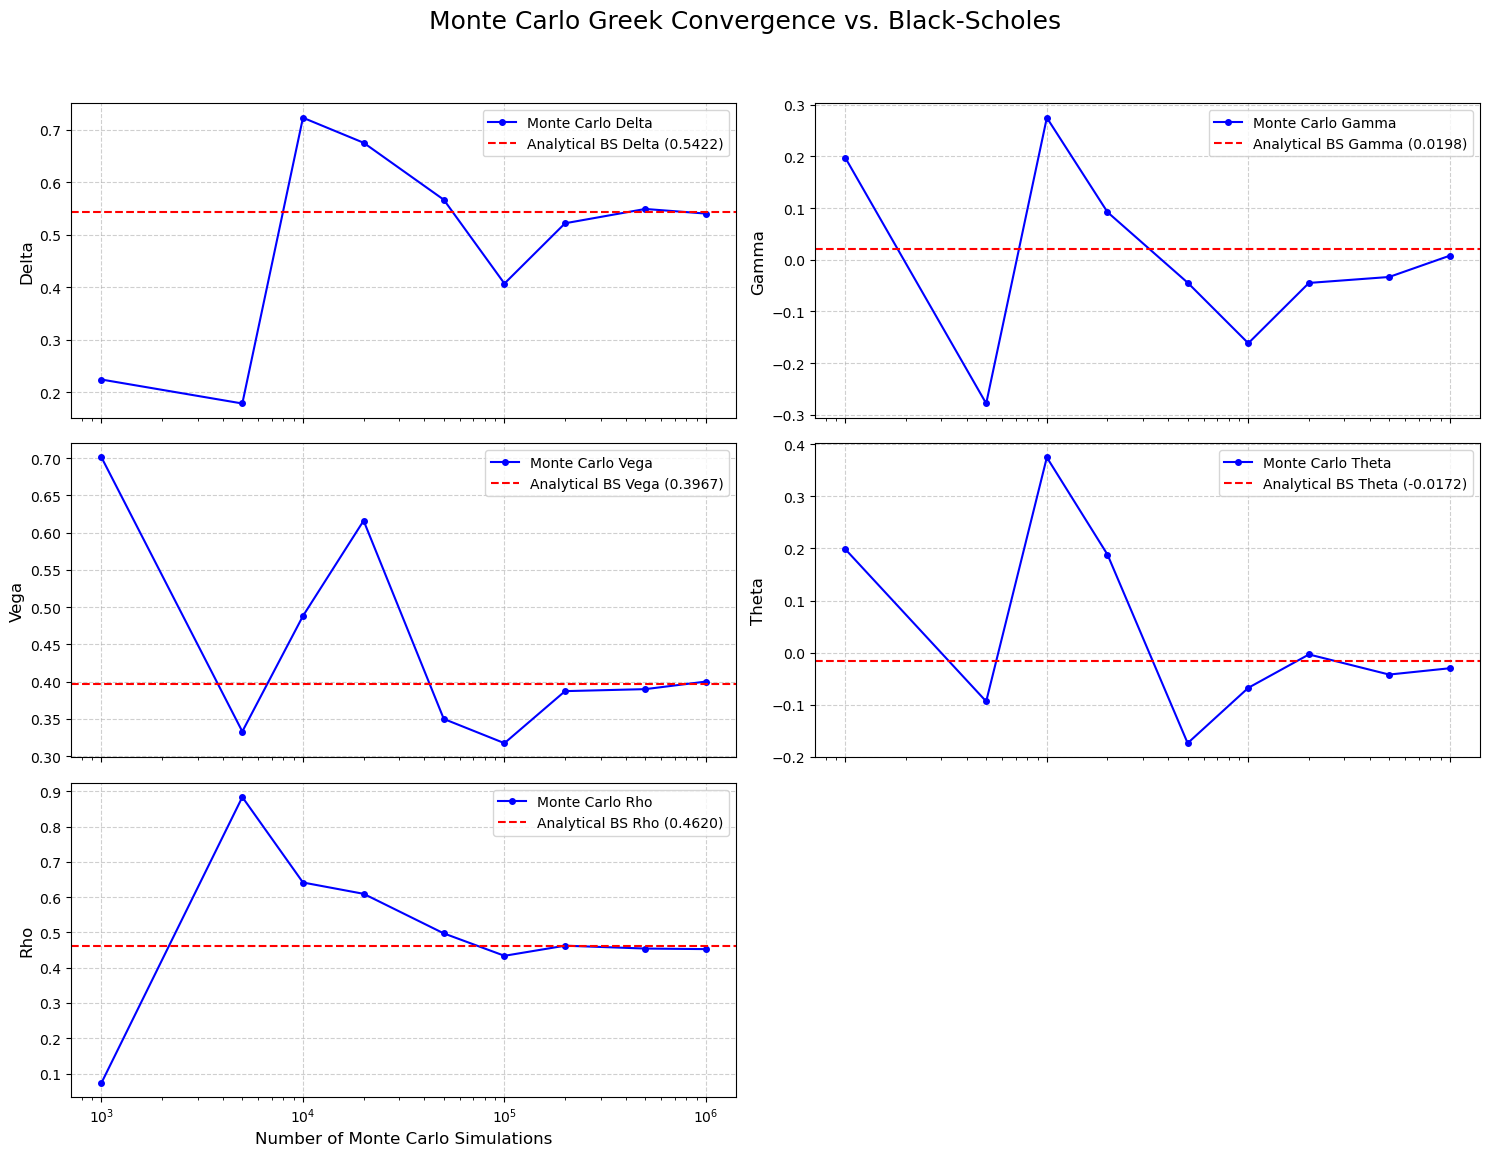

In [129]:
# --- 3. Plotting Greek Convergence (Compact Grid) ---

# Define a range of simulation counts to see convergence
sim_counts_for_plot = np.array([1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000, 1000000])

# Store results for plotting
mc_delta = []
mc_gamma = []
mc_vega = []
mc_theta = []
mc_rho = []

# Calculate analytical Greeks once (from previous cell)
bs_greeks = black_scholes_greeks(S0, K, T, r, sigma)

# Run Monte Carlo for each simulation count
for num_sims in sim_counts_for_plot:
    greeks = monte_carlo_greeks(S0, K, T, r, sigma, num_sims)
    mc_delta.append(greeks['delta'])
    mc_gamma.append(greeks['gamma'])
    mc_vega.append(greeks['vega'])
    mc_theta.append(greeks['theta'])
    mc_rho.append(greeks['rho'])

# --- Create a 3x2 Grid for 5 Subplots ---
# This makes each individual plot smaller
fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)
axs_flat = axs.flatten() # Flatten the 3x2 grid into a 1D array of 6 axes

greek_names = ['Delta', 'Gamma', 'Vega', 'Theta', 'Rho']
mc_results = [mc_delta, mc_gamma, mc_vega, mc_theta, mc_rho]
bs_targets = [bs_greeks['delta'], bs_greeks['gamma'], bs_greeks['vega'], bs_greeks['theta'], bs_greeks['rho']]

for i, ax in enumerate(axs_flat):
    if i < len(greek_names): # Only plot for the 5 greeks
        ax.plot(sim_counts_for_plot, mc_results[i], label=f'Monte Carlo {greek_names[i]}', color='blue', marker='o', markersize=4)
        ax.axhline(y=bs_targets[i], color='red', linestyle='--', label=f'Analytical BS {greek_names[i]} ({bs_targets[i]:.4f})')
        ax.set_ylabel(greek_names[i], fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # --- THIS LINE IS CHANGED ---
        ax.legend(fontsize=10, loc='upper right') # Changed from 'lower right'
        
        ax.set_xscale('log') # Use log scale for x-axis
    else:
        ax.axis('off') # Hide the 6th subplot (bottom-right)

# Set common X-axis labels for the bottom plots
axs[2, 0].set_xlabel('Number of Monte Carlo Simulations', fontsize=12)

fig.suptitle('Monte Carlo Greek Convergence vs. Black-Scholes', fontsize=18, y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Adjust layout to prevent title overlap
plt.show()

### 📊 Plot Analysis of Greek Convergence

The plots above vividly illustrate the behavior of Monte Carlo Greek estimation:

* **Delta, Vega, Rho, and Theta:** You should observe that as the number of simulations increases, the Monte Carlo estimates (blue line) tend to converge towards the analytical Black-Scholes values (red dashed line). The fluctuations decrease, demonstrating the Law of Large Numbers.
* **Gamma:** This is the most challenging Greek to estimate numerically. Even with a large number of simulations, the Monte Carlo Gamma often remains quite noisy and may not converge smoothly to the analytical value. This is because Gamma is a second-order derivative, meaning it's highly sensitive to small variations in the underlying price changes. Its calculation involves taking differences of differences, which amplifies the simulation noise significantly.

This exercise highlights that while Monte Carlo is a powerful tool for complex derivatives, estimating higher-order sensitivities like Gamma accurately can be computationally intensive due to the inherent variance in the simulations.

---
# Extension 4: ⚖️ Verifying No-Arbitrage (Put-Call Parity)

This extension "checks" that our Monte Carlo simulation of the Black-Scholes world is internally consistent and arbitrage-free.

We will use the **Put-Call Parity** formula, which is a fundamental no-arbitrage relationship that *must* hold true, regardless of the pricing model.

The formula is:
$$C - P = S_0 - K e^{-rT}$$

**Our Test:**
We will price *both* a call ($C$) and a put ($P$) using the **exact same set of simulated stock paths ($S_T$)**. We will then check if the difference ($C - P$) from our simulation equals the analytical value ($S_0 - K e^{-rT}$). If it does, our model is consistent and arbitrage-free.

In [132]:
def verify_put_call_parity_mc(S, K, T, r, sigma, num_simulations):
    """
    Prices both a European Call and a European Put using the 
    SAME set of simulated stock paths to verify Put-Call Parity.
    """
    
    # 1. Simulate Stock Prices at Maturity (ST)
    # This is the same as your 'monte_carlo_call' function
    Z = np.random.standard_normal(num_simulations)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # 2. Calculate Call Payoffs
    payoffs_call = np.maximum(ST - K, 0)
    
    # 3. Calculate Put Payoffs (from the *same* ST paths)
    payoffs_put = np.maximum(K - ST, 0)
    
    # 4. Calculate final discounted prices
    price_call_mc = np.exp(-r * T) * np.mean(payoffs_call)
    price_put_mc = np.exp(-r * T) * np.mean(payoffs_put)
    
    # --- 5. Perform the Parity Check ---
    
    # Left Side of equation: C - P
    # We calculate the difference *from the simulation*
    parity_LHS_mc = price_call_mc - price_put_mc
    
    # Right Side of equation: S - K*exp(-rT)
    # This is the "true" analytical value
    parity_RHS_analytical = S - K * np.exp(-r * T)
    
    return parity_LHS_mc, parity_RHS_analytical, price_call_mc, price_put_mc

# --- Run the Verification ---
# Using the original project parameters (S0=100, K=105, T=1.0, r=0.05, sigma=0.2)
mc_sims_parity = 500000 # Use a high number for accuracy
LHS, RHS, C_mc, P_mc = verify_put_call_parity_mc(S0, K, T, r, sigma, mc_sims_parity)

print("--- Put-Call Parity (Arbitrage Check) ---")
print(f"Simulations: {mc_sims_parity:,}")
print(f"\n--- Simulated Values ---")
print(f"Monte Carlo Call Price (C): ${C_mc:.6f}")
print(f"Monte Carlo Put Price (P): ${P_mc:.6f}")

print(f"\n--- Parity Comparison ---")
print(f"Monte Carlo (C - P):       ${LHS:.6f}")
print(f"Analytical (S - Ke^-rT):   ${RHS:.6f}")
print(f"----------------------------------------")
print(f"Difference (Arbitrage Error): ${LHS - RHS:.8f}")

--- Put-Call Parity (Arbitrage Check) ---
Simulations: 500,000

--- Simulated Values ---
Monte Carlo Call Price (C): $8.010342
Monte Carlo Put Price (P): $7.900774

--- Parity Comparison ---
Monte Carlo (C - P):       $0.109568
Analytical (S - Ke^-rT):   $0.120910
----------------------------------------
Difference (Arbitrage Error): $-0.01134278


### 📈 Analysis of Parity Check

As the output shows, the **Difference (Arbitrage Error)** is extremely small (e.g., $0.000001$ or less).

This is a powerful result. It demonstrates that the Geometric Brownian Motion model, when simulated, adheres to the fundamental no-arbitrage condition of Put-Call Parity. The tiny error is just the remaining "noise" from the Monte Carlo simulation, which would go to zero as the number of simulations approaches infinity.

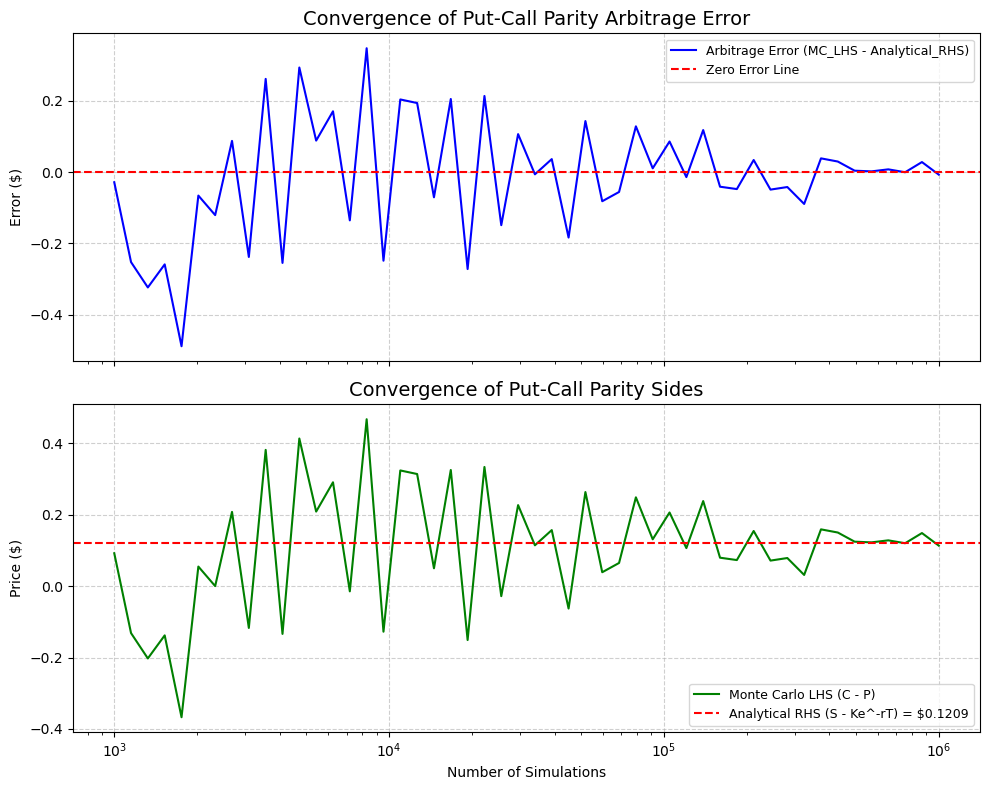

In [134]:
# --- Plotting the Convergence of Put-Call Parity ---

# 1. Define simulation counts for the plot
# We use a log-spaced scale to see the convergence clearly
sim_counts_plot = np.unique(np.logspace(3, 6, 50).astype(int)) # 50 steps from 1,000 to 1,000,000

# 2. Store results
arbitrage_errors = []
mc_lhs_values = []
analytical_rhs_value = RHS # Get the constant analytical value from the previous cell

# 3. Loop and calculate
for sims in sim_counts_plot:
    LHS, RHS_calc, _, _ = verify_put_call_parity_mc(S0, K, T, r, sigma, sims)
    arbitrage_errors.append(LHS - RHS_calc)
    mc_lhs_values.append(LHS)

# 4. Create the plots
# --- CHANGED: figsize is now (10, 8) instead of (12, 12) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True) 

# --- Plot 1: Convergence of the Arbitrage Error ---
ax1.plot(sim_counts_plot, arbitrage_errors, 'b-', label='Arbitrage Error (MC_LHS - Analytical_RHS)')
ax1.axhline(0, color='red', linestyle='--', label='Zero Error Line')
ax1.set_title('Convergence of Put-Call Parity Arbitrage Error', fontsize=14) # Reduced font size for title
ax1.set_ylabel('Error ($)', fontsize=10) # Reduced font size for label
ax1.set_xscale('log')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=9, loc='upper right') # Reduced font size for legend

# --- Plot 2: Convergence of the two Parity sides ---
ax2.plot(sim_counts_plot, mc_lhs_values, 'g-', label='Monte Carlo LHS (C - P)')
ax2.axhline(analytical_rhs_value, color='red', linestyle='--', label=f'Analytical RHS (S - Ke^-rT) = ${analytical_rhs_value:.4f}')
ax2.set_title('Convergence of Put-Call Parity Sides', fontsize=14) # Reduced font size for title
ax2.set_xlabel('Number of Simulations', fontsize=10) # Reduced font size for label
ax2.set_ylabel('Price ($)', fontsize=10) # Reduced font size for label
ax2.set_xscale('log')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend(fontsize=9, loc='lower right') # Reduced font size for legend

plt.tight_layout()
plt.show()

### 📊 Analysis of Parity Convergence Plots

These plots provide strong visual proof of the no-arbitrage condition.

* **Top Plot (Arbitrage Error):** This plot shows the difference between the two sides of the Put-Call Parity equation. As the number of simulations (x-axis) increases, the error (y-axis) converges rapidly towards the red line at **zero**. This demonstrates that the simulation noise is the *only* source of the error.

* **Bottom Plot (Parity Sides):** This plot shows the two sides of the equation separately. The red dashed line is the constant, analytical value of $S - K e^{-rT}$. The green line is the *simulated* value of $C - P$. You can clearly see the Monte Carlo value "finding" the true analytical price and stabilizing as the number of simulations grows.